<a href="https://colab.research.google.com/github/guldenturgay/news-articles-classification/blob/main/ML_Challenge_Gulden_Turgay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

In this project, I will be working on a text classification model with Python and Tensorflow. Data will be acquired from [this Google Drive folder](https://drive.google.com/drive/folders/1k7MNpw_huZTL9opXU9e7u6M8phupPih7).

### Table of contents
- [Exploratory Data Analysis](#EXPLORATORY-DATA-ANALYSIS)
- [Pre-Processing](#PRE-PROCESSING)
- [Model Building](#MODEL-BUILDING)
- [Test With New Data](#TEST-WITH-NEW-DATA)
- [Conclusion](#CONCLUSION)



# EXPLORATORY DATA ANALYSIS

I'll start with exploring the training data. First import libraries and modules.

In [ ]:
# Import libraries and modules
from tensorflow.keras import backend as K
K.clear_session()
import tensorflow as tf
from tensorflow import keras
import os
import codecs 
from bs4 import BeautifulSoup
import pandas as pd
import re
import string
import nltk

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading The Data From The Source

Since the data is located in a Google Drive folder, I use the code below from Stackoverflow (link provided) to load the data to Google Colab. in order to fetch the files and save to Google Colab environment it requires access and a verification code provided by login.

In [ ]:
#https://stackoverflow.com/posts/48385944/revisions
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('content/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
#  Google Drive folder ID is '1k7MNpw_huZTL9opXU9e7u6M8phupPih7'
file_list = drive.ListFile(
    {'q': "'1k7MNpw_huZTL9opXU9e7u6M8phupPih7' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


title: README.txt, id: 1YIEVrXbQbAZadZweNqmH4KO6wmErTiZR
downloading to content/data/README.txt
title: lewis.dtd, id: 1mT2ORVn2q-DzO-hI1mQs5poKaMcJ713P
downloading to content/data/lewis.dtd
title: feldman-cia-worldfactbook-data.txt, id: 1wCkZMJR-HPsudl2wNQDhAw2DUAujM3zm
downloading to content/data/feldman-cia-worldfactbook-data.txt
title: cat-descriptions_120396.txt, id: 1juoEstxpegKCDL0yncGhhgZWT2hNGC12
downloading to content/data/cat-descriptions_120396.txt
title: all-people-strings.lc.txt, id: 17NrxST0DdPWSDxxTjYssfMm50uY1Woz6
downloading to content/data/all-people-strings.lc.txt
title: all-orgs-strings.lc.txt, id: 1favlyG2c1JcLuNxIC-JlD1Pin3ZIBEv4
downloading to content/data/all-orgs-strings.lc.txt
title: all-topics-strings.lc.txt, id: 1dUGW1gUMqdGA5W8_iRbJaOZd5rbisWMv
downloading to content/data/all-topics-strings.lc.txt
title: all-places-strings.lc.txt, id: 15f0XJ24SqV97PS4-5YTR8zGmPQGorWHm
downloading to content/data/all-places-strings.lc.txt
title: all-exchanges-strings.lc.txt,

## Reading The Files

Now I have the data in my local computer (Google Colab in this case). The below function reads the .sgm file, extracts the text body and topics for each news articles in the files and creates a Pandas dataframe. I use BeautifulSoup to scrape the text and topics.

In [ ]:
# Function to read the files and extract the text body and topics
def extract_text(source):
    """
    This function takes an .sgm file and returns a pandas dataframe. 

    Inputs: 
      source: File path in a string format.

    Returns:
      A Pandas dataframe, one column for text body, obe column for the labels belonging to the text.
    """

    text_body = []
    topic_names = []

    # Scrapes the content from the file
    # https://stackoverflow.com/questions/22216076/unicodedecodeerror-utf8-codec-cant-decode-byte-0xa5-in-position-0-invalid-s
    with codecs.open(filename,'rb') as f:
      lines = f.read()
      soup = BeautifulSoup(lines, 'html.parser')
      documents = soup.find_all('body')
      topics = soup.find_all('topics')

      # https://www.py4u.net/discuss/1403276
      for document in documents:
        text_body.append(document.text)
    
      for topic in topics:
        topic_names.append(str(topic))

    # Creates a list for the labels of each text body
    topic_names = [[topic_list] for topic_list in topic_names]

    topic_list_cleaned=[]
    for topic_list in topic_names:
      if topic_list[0] == str(topic_list[0]):
        match = re.findall('(?<=>)(\w+.\w+)(?=<)', topic_list[0])
        topic_list_cleaned.append(match)

    # Creates a dataframe
    df_text = pd.DataFrame(text_body, columns=['text'])
    df_label = pd.DataFrame()
    df_label['label'] = topic_list_cleaned
    df = pd.concat([df_text, df_label], axis=1)
            
    return df

In [ ]:
# Read the files in the source folder and convert them to a pandas dataframe
source = '/content/content/data'

files_extracted=[]

for file in os.listdir(source):
  if file.endswith('.sgm'):
    filename = os.path.join(source, file)
    files_extracted.append(filename)

list_of_dataframes = []

for filename in files_extracted:
  df = extract_text(filename)
  list_of_dataframes.append(df)

df = pd.concat(list_of_dataframes)

In [ ]:
df.shape

(21000, 2)

## Check the Empty Rows

In order to provide a consistent and clean data for the model, I will check and clean and empty rows.

In [ ]:
df.head()

,text,label
0,Paxar Corp said it has\nacquired Thermo-Print ...,[acq]
1,"Shr 10 cts vs 32 cts\n Net 975,000 vs 3,145...",[earn]
2,Key Tronic corp said it has\nreceived contract...,[]
3,Canadian Bashaw Leduc Oil and\nGas Ltd said it...,[acq]
4,Entourage International Inc said it had\na fir...,[earn]


In [ ]:
print('Number of NaN values: \n',df.isnull().sum())

Number of NaN values: 
 text     2417
label       0
dtype: int64


In [ ]:
# Drop NaN values
df.dropna(axis=0, inplace=True)
print('Length of the dataframe: ', len(df), '\n')
df.tail()

Length of the dataframe:  18583 



,text,label
916,The European Community (EC) farmers'\nand farm...,[earn]
917,Producers zinc stocks in Organization\nfor Eco...,[]
918,"Higher world oil prices, coupled with a\nnew r...",[]
919,The rebate granted at yesterday's EC\nsugar te...,[cpi]
920,26 weeks ended Dec 28\n Net shr 25.9 cents ...,[]


## Total Number of Each Topic

Now I'd like to see how the label distribution is in this dataset. If it's balanced it's a YAY! but if it's not, it needs an additional cleaning.

First I will one-hot encode all the labels for a convenience to feed the data to the model and for a further EDA.

In [ ]:
# https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
# Creates a Multi label binarizer
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Creates a new dataframe with the binarized labels
df_binarized = pd.DataFrame(mlb.fit_transform(df.pop('label')),
                          columns=mlb.classes_,
                          index=df.index)
df=pd.concat([df, df_binarized], axis=1)

In [ ]:
print(df.shape)
df.head()

(18583, 116)


,text,acq,alum,austdlr,barley,bop,can,carcass,castor-oil,castorseed,citruspulp,cocoa,coconut,coconut-oil,coffee,copper,copra-cake,corn,cornglutenfeed,cotton,cotton-oil,cottonseed,cpi,cpu,crude,cruzado,dfl,dlr,dmk,earn,f-cattle,fishmeal,fuel,gas,gnp,gold,grain,groundnut,groundnut-oil,heat,...,plywood,pork-belly,potato,propane,rand,rape-meal,rape-oil,rapeseed,red-bean,reserves,retail,rice,ringgit,rubber,rupiah,rye,saudriyal,sfr,ship,silver,sorghum,soy-meal,soy-oil,soybean,stg,strategic-metal,sugar,sun-meal,sun-oil,sunseed,tapioca,tea,tin,trade,veg-oil,wheat,wool,wpi,yen,zinc
0,Paxar Corp said it has\nacquired Thermo-Print ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Shr 10 cts vs 32 cts\n Net 975,000 vs 3,145...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Key Tronic corp said it has\nreceived contract...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Canadian Bashaw Leduc Oil and\nGas Ltd said it...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Entourage International Inc said it had\na fir...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we have 116 columns, 1 for the text and the rest for the labels. Let's count them.

In [ ]:
# https://stackoverflow.com/posts/56720533/revisions
# Creates a new row for each label's count
df.loc['Total'] = df.sum(numeric_only=True, axis=0)
df.tail()

,text,acq,alum,austdlr,barley,bop,can,carcass,castor-oil,castorseed,citruspulp,cocoa,coconut,coconut-oil,coffee,copper,copra-cake,corn,cornglutenfeed,cotton,cotton-oil,cottonseed,cpi,cpu,crude,cruzado,dfl,dlr,dmk,earn,f-cattle,fishmeal,fuel,gas,gnp,gold,grain,groundnut,groundnut-oil,heat,...,plywood,pork-belly,potato,propane,rand,rape-meal,rape-oil,rapeseed,red-bean,reserves,retail,rice,ringgit,rubber,rupiah,rye,saudriyal,sfr,ship,silver,sorghum,soy-meal,soy-oil,soybean,stg,strategic-metal,sugar,sun-meal,sun-oil,sunseed,tapioca,tea,tin,trade,veg-oil,wheat,wool,wpi,yen,zinc
917,Producers zinc stocks in Organization\nfor Eco...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
918,"Higher world oil prices, coupled with a\nnew r...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
919,The rebate granted at yesterday's EC\nsugar te...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
920,26 weeks ended Dec 28\n Net shr 25.9 cents ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Total,NaN,2108.0,58.0,3.0,46.0,98.0,2.0,71.0,2.0,1.0,1.0,72.0,6.0,6.0,134.0,66.0,3.0,218.0,1.0,55.0,3.0,1.0,99.0,3.0,546.0,1.0,3.0,191.0,10.0,3491.0,3.0,2.0,25.0,55.0,137.0,114.0,557.0,8.0,2.0,22.0,...,1.0,2.0,5.0,5.0,2.0,1.0,7.0,34.0,1.0,73.0,24.0,60.0,1.0,41.0,1.0,2.0,3.0,3.0,248.0,34.0,31.0,25.0,22.0,105.0,18.0,27.0,159.0,2.0,7.0,15.0,3.0,14.0,26.0,482.0,118.0,282.0,2.0,29.0,61.0,39.0


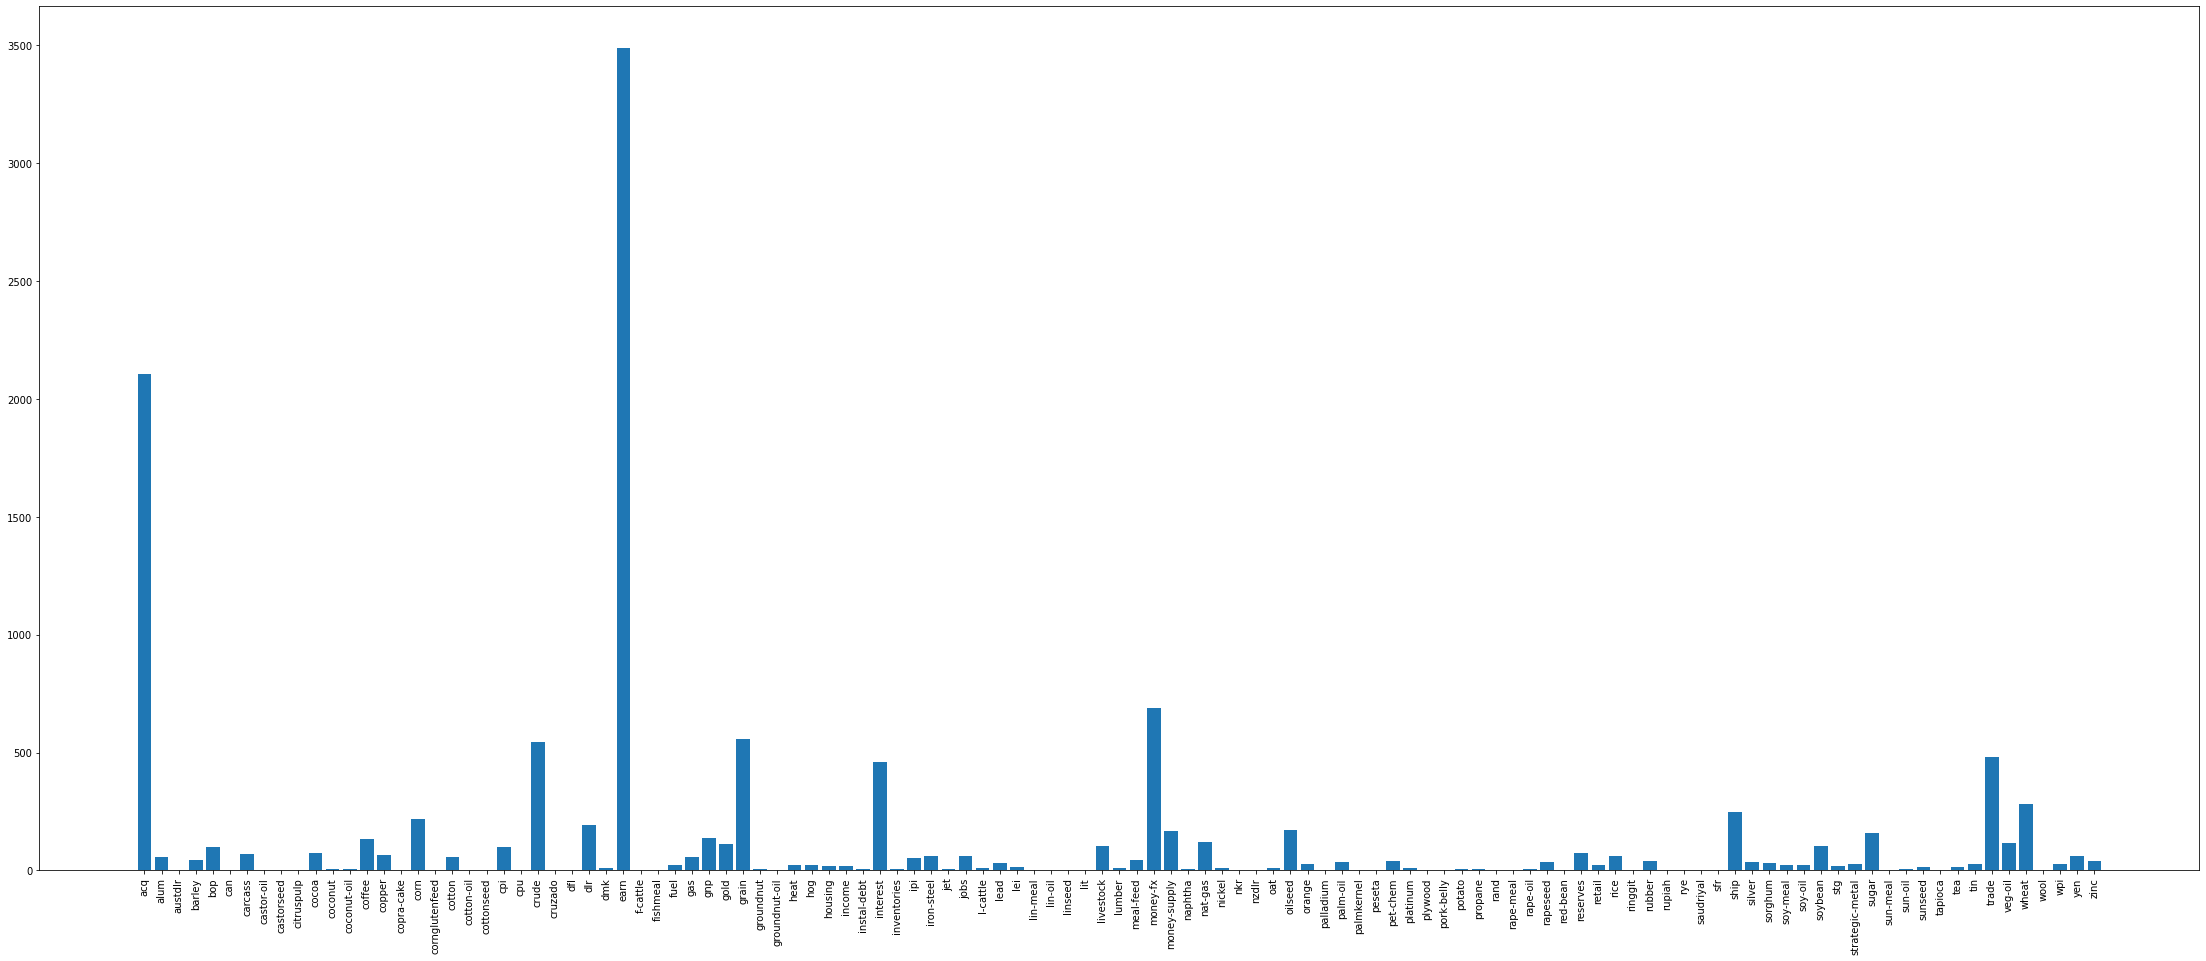

In [ ]:
# Visualizes the counts
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,5,3])
x = df.columns[1:]
y = df.loc['Total'][1:]
ax.bar(x, y)
plt.xticks(rotation=90)
plt.show()

# PRE-PROCESSING

In the preprocessing, I will preprocess the data (Huh!). When I checked the label counts I see that it's **EXTREMELY UNBALANCED**. It will be very difficult for a model to learn from this type of data. So, as the next step, I will only keep the labels with a count of more than 1000.

### Keep Some Columns Only

In [ ]:
number_of_repetition = pd.DataFrame(df.iloc[:,1:].loc['Total'])
number_of_repetition.sort_values('Total',ascending=False)
repeated_1000 = list((number_of_repetition[number_of_repetition.Total>=1000.0]).index)
print(len(repeated_1000))

2


In [ ]:
# Creates a copy of the dataframe to modify and keep only some columns
df_copy = df.copy()
df_copy = df_copy[repeated_1000]
df_copy['text'] = df['text']
print(df_copy.shape)
df_copy.head()

(18584, 3)


,acq,earn,text
0,1.0,0.0,Paxar Corp said it has\nacquired Thermo-Print ...
1,0.0,1.0,"Shr 10 cts vs 32 cts\n Net 975,000 vs 3,145..."
2,0.0,0.0,Key Tronic corp said it has\nreceived contract...
3,1.0,0.0,Canadian Bashaw Leduc Oil and\nGas Ltd said it...
4,0.0,1.0,Entourage International Inc said it had\na fir...


### Text Cleaning

Now the text needs some cleaning. Below function will provide that.

In [ ]:
# Function to clean text
def clean_text(text):
    """
    This function takes a corpus and returns a cleaned corpus. 

    Inputs: 
      text: Body of text in a string format.

    Returns:
      A cleaned corpus.
    """
    # Stopwords in English language
    stopword = stopwords.words('english')

    # Lemmatizer
    wn = nltk.WordNetLemmatizer()

    # Remove new line character
    text = re.sub('\n', ' ', text)

    # Remove numeric characters
    text = re.sub('\d', '', text)
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    text = text.lower()

    # Remove stopwords
    for word in text:
      if word not in stopword:
        word=word

    # Lemmatize the words
    for word in text:
      word = wn.lemmatize(word)
    
    # Return text
    return text 


In [ ]:
# Clean all the rows in the text column
df_copy.text = df_copy.text.apply(lambda x: clean_text(str(x)))
df_copy.text.head()

0    paxar corp said it has acquired thermoprint gm...
1    shr  cts vs  cts     net  vs      sales  mln v...
2    key tronic corp said it has received contracts...
3    canadian bashaw leduc oil and gas ltd said it ...
4    entourage international inc said it had a firs...
Name: text, dtype: object

### Number of Words in Each Text Body

I'm just curious about the word counts in each news articles. Let's see if it's worth to add as a new feature to our data.

In [ ]:
df_text_length = pd.DataFrame(df_copy.text)

df_text_length['text_length'] = df_text_length.text.apply(lambda x: len(x.strip().split(' ')))
df_text_length.head()

,text,text_length
0,paxar corp said it has acquired thermoprint gm...,23
1,shr cts vs cts net vs sales mln v...,27
2,key tronic corp said it has received contracts...,62
3,canadian bashaw leduc oil and gas ltd said it ...,54
4,entourage international inc said it had a firs...,97


(0.0, 1000.0)

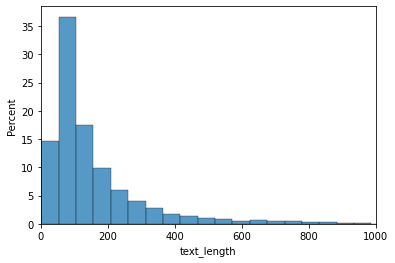

In [ ]:
import seaborn as sns
x = df_text_length.text_length


sns.histplot(x, bins=100, stat='percent').set_xlim(0,1000)

The chart above shows that majority of the articles have a word count that is less than 200. It can be added as a new feature to the data.

### Train/Test Split

In this step, I will split my data as train and test sets. Train set will be 75% of the data and the remaining 25% will be the test set.

In [ ]:
from sklearn.model_selection import train_test_split
train_corpus, test_corpus, train_labels, test_labels = train_test_split(df_copy['text'], df_copy.iloc[:,:-1], test_size=0.25, random_state=42, shuffle=True)

In [ ]:
type(train_corpus)

pandas.core.series.Series

Since a Tensorflow model expects an array, not a Pandas series, I will convert all the data to Numpy arrays.

In [ ]:
# Converts the data to Numpy arrays
import numpy as np

training_corpus = np.array(train_corpus)
training_labels = np.array(train_labels)
testing_corpus = np.array(test_corpus)
testing_labels = np.array(test_labels)

n_labels = training_labels.shape[1]

#### Check the Balance Between Train and Test Sets

Let's see if train and test sets are similarly balanced.

In [ ]:
train_labels.sum(numeric_only=True, axis=0)

acq     3671.0
earn    6111.0
dtype: float64

In [ ]:
test_labels.sum(numeric_only=True, axis=0)

acq     545.0
earn    871.0
dtype: float64

So, the label ratio in train set and test set are not exactly the same but they are close enough.

# MODEL BUILDING

In the model building part, the below code first will try loading a pre-saved model that I built and saved in my personal Google Drive. It will ask for a login for verification. The below code also will build the model from scratch if loading the model from the Drive is not successful. 

The model is a 6-layers deep learning model with the activation function 'tanh' in hidden layers and 'sigmoid' in the output layer.

For the embedding layer, I used Tensorflow pre-trained embeddings that are trained on English Google News 7B corpus.

In order to prevent overfitting, I used Ridge Regression regularizer in some hidden layers. I also used earlystopping and learning rate scheduler. Earlystopping monitors the binary accuracy for its maximum value for 10 epochs until it stops increasing. And the learning rate scheduler is adjusted to decrease exponentially starting from 0.0002. 

In the compiling stage, the loss function is 'binary_crossentropy', the optimizer is SGD and the metric is 'binary_accuracy'.

In [ ]:
# Try loading the pre-saved model. If cannot, build and train the model.

try:
  #https://stackoverflow.com/posts/48385944/revisions

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # choose a local (colab) directory to store the data.
  local_download_path = os.path.expanduser('content/saved_model')
  assets = os.path.expanduser('content/saved_model/assets')
  variables = os.path.expanduser('content/saved_model/variables')

  
  os.makedirs(local_download_path)
  os.makedirs(assets)
  os.makedirs(variables)

  # 2. Auto-iterate using the query syntax
  #    https://developers.google.com/drive/v2/web/search-parameters

  # File IDs in queries below. File ID: the last part of the file link
  files_assets = drive.ListFile({'q': "'1-9EbCGGL0kfkgd78jvZvGu0HZ-wwgDSQ' in parents"}).GetList()
  files_variables = drive.ListFile({'q': "'1--rTTlM02zdhw1p7iT7ROeIq4E_Fbkmr' in parents"}).GetList()
  file_list = drive.ListFile({'q': "'1hM_rwQLHD8_d3yWDjEJ5TdJBzlzpWpce' in parents"}).GetList()


  for f in files_assets:
    # 3. Create & download by id.
    fname = os.path.join(assets, f['title'])
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

  for f in files_variables:
    # 3. Create & download by id.
    fname = os.path.join(variables, f['title'])
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

  try:  
    for f in file_list:
      # 3. Create & download by id.
      fname = os.path.join(local_download_path, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)

  except: pass

  # Load the model
  model= keras.models.load_model('content/saved_model')

except:
  import tensorflow_hub as hub

  # Build the model
  model = keras.Sequential([
      hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2", dtype=tf.string, input_shape=[], output_shape=[50]),
      keras.layers.Dense(64, activation='tanh',kernel_regularizer='l2'),
      #keras.layers.Dropout(0.1),
      keras.layers.Dense(32, activation='tanh',kernel_regularizer='l2'),
      #keras.layers.Dropout(0.1),
      keras.layers.Dense(16, activation='tanh',kernel_regularizer='l2'),
      keras.layers.Dense(8, activation='tanh'),
      keras.layers.Dense(n_labels, activation='sigmoid')
  ])

  print(model.summary())

  from keras import callbacks

  # Define early stopping to prevent overfit
  earlystopping = callbacks.EarlyStopping(monitor='binary_accuracy',
                                          mode='max',
                                          patience=10,
                                          restore_best_weights=True,
                                          verbose=1)

  # Exponantial Learning Rate Scheduler function
  def scheduler(epoch, lr):
      if epoch < 3:
          return lr
      else:
          return lr*tf.math.exp(-0.1)

  # Define lr scheduler to prevent overfit
  lr_scheduler = callbacks.LearningRateScheduler(scheduler, verbose=1)

  
  model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(0.0002),
              metrics=['binary_accuracy'])
              
  history = model.fit(training_corpus, training_labels,
                    batch_size = 128,
                    epochs=100,
                    verbose=1,
                    validation_split=0.3,
                    callbacks=[lr_scheduler, earlystopping]) 
  
  # Printing a graph showing the accuracy and loss changes during the training phase
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='right')
  plt.show()

In [ ]:
# Connect to Google Drive and save the model there 
 
# from google.colab import drive
# drive.mount('/content/drive')

# Save the model
  #model.save('/content/drive/MyDrive/ML_challenge')

## Model Evaluation

I will evaluate the model with the test set to get the binary accuracy score and loss. I will also create a classification report to see the precision and recall values for for each of the two labels('acq' and 'earn') in the test set.

In [ ]:
model.evaluate(testing_corpus, testing_labels)

146/146 [==============================] - 1s 3ms/step - loss: 1.7562 - binary_accuracy: 0.8319


[1.756176233291626, 0.8318983912467957]

In [ ]:
# Get the predictions from the test set
predicted_test = model.predict(test_corpus)
predicted_test

predictions = []
for row in predicted_test:
  idx = np.argmax(row)
  predictions.append(idx)

print(len(predictions))
test_labels.head(10)

4646


,acq,earn
109,0.0,0.0
420,0.0,0.0
535,0.0,1.0
503,0.0,0.0
547,0.0,0.0
12,0.0,0.0
403,0.0,0.0
403,0.0,0.0
523,0.0,1.0
233,0.0,0.0


In [ ]:
predicted_test = model.predict(test_corpus)
predicted_test

array([[0.40773237, 0.54049736],
       [0.38485467, 0.3478552 ],
       [0.38301373, 0.42303216],
       ...,
       [0.34374774, 0.3916471 ],
       [0.36927307, 0.36561623],
       [0.3300377 , 0.3871543 ]], dtype=float32)

In [ ]:
# Get the best possible label for each text and create a list. Label 0 represents 'acq' while 1 represents 'earn'

test_output=[]
for index, row in test_labels.iterrows():
  idx= np.argmax([row[0],row[1]])
  test_output.append(idx)

test_output[:20]

[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]

In [ ]:
# Classification report for test data
from sklearn.metrics import classification_report
target_names = test_labels.columns
print(classification_report(test_output, predictions, target_names=target_names))

              precision    recall  f1-score   support

         acq       0.82      0.28      0.41      3780
        earn       0.19      0.73      0.30       866

    accuracy                           0.36      4646
   macro avg       0.50      0.50      0.36      4646
weighted avg       0.70      0.36      0.39      4646



It's not really the best output in terms of accuracy scores. But I always like to check the precision and recall values for the classification tasks. So, for this particular task, classifiying the class 'earn' is the most important part. Even though the f1-score is low around 0.30, the recall value is 0.73 which means 73 out of 100 'earn' labels predicted correctly. But when we check the precision value, we can see that 19% of all predictions for 'earn' were actually 'earn'. But I like the recall value. I'll take it.

# TEST WITH NEW DATA

In this step, you can test the model with your data. The function below expects either an .sgm file formatted similarly as the data used for training or a corpus (raw text). If an .sgm file provided, it will return an evaluation score and a classification report. If raw text provided, it will return a prediction for a label that your text might belong to.

You can see the instructions and examples below.

In [ ]:
source = 'your .sgm file path or raw text'

def test_new_data(source):
    """ This function takes an .sgm file and returns the classification report . 

    Inputs: 
      source_file: path of the file source in a string format

    Returns:
      Evaluation results of the corpus as the function loss and binary accuracy.
      Classification report for classes 'acq' and 'earn'.
            
    """
    # If and .sgm file provided do this
    if source.endswith('.sgm'):

      # Extract text body and labels
      extracted_dataframe = extract_text(source)

      
      # https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list

      from sklearn.preprocessing import MultiLabelBinarizer
      mlb = MultiLabelBinarizer()
      df_binarized = pd.DataFrame(mlb.fit_transform(extracted_dataframe.pop('label')),
                            columns=mlb.classes_,
                            index=extracted_dataframe.index)
      extracted_dataframe=pd.concat([extracted_dataframe, df_binarized], axis=1)

      # Clean the text
      extracted_dataframe.text = extracted_dataframe.text.apply(lambda x: clean_text(str(x)))
      new_test_corpus = extracted_dataframe.text
      new_test_labels = extracted_dataframe[['acq','earn']]
      print(model.evaluate(new_test_corpus, new_test_labels))


      test_output=[]
      for index, row in new_test_labels.iterrows():
        idx = np.argmax([row[0],row[1]])
        test_output.append(idx)

      #Classification report for test data
      predicted_test = model.predict(new_test_corpus)
      predicted_test

      predictions = []
      for row in predicted_test:
        idx = np.argmax(row)
        predictions.append(idx)

      from sklearn.metrics import classification_report
      target_names = new_test_labels.columns
      print(classification_report(test_output, predictions, target_names=target_names))

    # If a raw text provided, do this
    elif type(source)==str:
      preds = model.predict([source])
      predicted_class = np.argmax(preds)
      label_dict={0: 'acq',
                  1: 'earn'}  
      print('Your text belongs to the "{}" category'.format(label_dict[predicted_class]))

## Examples

In [ ]:
# Example for a file source
source= '/content/content/data/reut2-000.sgm'

test_new_data(source)

32/32 [==============================] - 0s 3ms/step - loss: 1.7858 - binary_accuracy: 0.7530
[1.7858260869979858, 0.753000020980835]
              precision    recall  f1-score   support

         acq       0.72      0.35      0.47       714
        earn       0.29      0.66      0.40       286

    accuracy                           0.44      1000
   macro avg       0.51      0.51      0.44      1000
weighted avg       0.60      0.44      0.45      1000



In [ ]:
# Example for a raw text source
source = """Sandoz AG said it planned a joint venture
to produce herbicides in the Soviet Union.
    The company said it had signed a letter of intent with the
Soviet Ministry of Fertiliser Production to form the first
foreign joint venture the ministry had undertaken since the
Soviet Union allowed Western firms to enter into joint ventures
two months ago.
    The ministry and Sandoz will each have a 50 pct stake, but
a company spokeswoman was unable to give details of the size of
investment or planned output."""

test_new_data(source)

Your text belongs to the "earn" category


# CONCLUSION

Even though the model evaluation gave a result of 0.83 accuracy rate for the test set, when we look into the precision and recall values we can see that it's not a model as good as the accuracy score claims. There are many ways to improve the model, including improving the data by get it more balanced. Given flexible time, the model can be improved by trying other optimizers, number of layers, number of neurons in each layer and even maybe different type of machine learning algorithms instead of neural networks.